In [1]:
## Libraries
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from insight.pv_model import pv_model_class
import cvxpy as cp
import pandas as pd
import os


In [2]:
# Constants and variables

Iscn = 8.21 # nominal short circuit current
Vocn = 32.9 # nominal open circuit voltage
Imp = 7.61 # array current at MPP
Vmp = 26.3 # array voltage at MPP
Pmax_e = Vmp * Imp # experimental array max power output
Kv = -0.123 # voltage temperature coefficient
Ki = 0.0032 # current temperature coefficient
Ns = 54 # number of series cells
Gn = 1000. # nominal irradiance
G = Gn
Tn = 25. + 273.15 # nominal operating temperature
T = Tn

Egap = 1.8 * 10 ** -19 # Bandgap of silicon (silicio cristalino)

err = 0.0001
inverter = 0.95
array_dim = [1, 1]

In [3]:
### Linear Program Example -- CVXPY

m = 15
n = 10
np.random.seed(1)
s0 = np.random.randn(m)
lamb0 = np.maximum(-s0, 0)
s0 = np.maximum(s0, 0)
x0 = np.random.randn(n)
A = np.random.randn(m, n)
b = A @ x0 + s0
c = -A.T @ lamb0

# Define and solve the CVXPY problem.
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize(c.T@x),
                 [A @ x <= b])
prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution is")
print(prob.constraints[0].dual_value)


## use '@' when doing multiplication between vectors and matrices -- turns them into scalars
## use '*' when doing multiplication between scalars and vectors or matrices


The optimal value is -15.220912605552861
A solution x is
[-1.10133381 -0.16360111 -0.89734939  0.03216603  0.6069123  -1.12687348
  1.12967856  0.88176638  0.49075229  0.8984822 ]
A dual solution is
[6.98805172e-10 6.11756416e-01 5.28171747e-01 1.07296862e+00
 3.93759300e-09 2.30153870e+00 4.25704434e-10 7.61206896e-01
 8.36906030e-09 2.49370377e-01 1.30187120e-09 2.06014070e+00
 3.22417207e-01 3.84054343e-01 1.59493839e-09]


## Helpful links:
1. https://www.cvxpy.org/tutorial/functions/index.html
2. https://www.cvxpy.org/examples/basic/linear_program.html


# charging constraints
p_cha >= 0
p_cha <= p_lim

# dischargin constraints
p_dis >= 0
p_dis <= p_lim

# SOC constraints
J >= 0
J <= J_max


In [6]:
## getting LMP data, etc

df = pd.read_csv(os.path.join("..//..//..//data", "LMP_data_201801_dalmp_TH_NP15_GEN-APND.csv"))
lmp = df["LMP"]
# lmp for Jan 2nd
lmp_oneday = lmp[17:41]

#df['INTERVALSTARTTIME_GMT'][17]

In [7]:
p_dem_df = pd.read_csv(os.path.join("..//..//..//data", "Demand_data_USA_WA_Seattle-Tacoma.727930_TMY2.csv"))

print(min(p_dem_df['Electricity:Facility [kWh](Hourly)']))

#p_dem_df.head()
#p_dem_df['Date/Time'][47]

0.394315391925397


In [6]:
### constants
# time step currently is ONE HOUR
# the day is currently JAN 2nd
# number of hours
n = 24

# power limit
p_lim = 5 * 10 ** 3
# state of charge max
# based off of max from demand data
J_max = 2.06 * 10 ** 3
J_init = 0.2 * 10 ** 3
J_eff = 1
# charge efficiency
cha_eff = 0.94
# discharge efficiency
dis_eff = 0.94
# power demand for Jan 2nd
p_dem = p_dem_df["Electricity:Facility [kWh](Hourly)"][23:47]
# power supplied by pv
# calculated for Jan 1, using TMYFormatting.ipynb
# this is for a 10x10 array (to match other values better)
p_pv = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
        3.687437411241854, 1887.4678324745719, 
        1569.092473952668, 7204.08116258169, 
        2473.208104704921, 1653.8375698519135, 
        2669.471806669538, 205.99573028765283, 
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

p_cha = cp.Variable(n)
p_dis = cp.Variable(n)
J = cp.Variable(n, nonneg=True)


constraints = [J[0] == J_eff * J_init + cha_eff * p_cha[0] - p_dis[0] / dis_eff]
constraints += [J[t] == J_eff * J[t-1] + cha_eff * p_cha[t] - p_dis[t] / dis_eff for t in range(1,n)]
constraints += [J[n-1] >= J_init]
constraints += [p_cha >= 0]
constraints += [p_cha <= p_lim]
constraints += [p_dis >= 0]
constraints += [p_dis <= p_lim]

# convert pandas Series into numpy array
_lmp = lmp_oneday.to_numpy()
p_dem = p_dem.to_numpy()
#J_const = np.array(J_const)

p_net = p_dem - p_pv + p_cha - p_dis

prob = cp.Problem(cp.Minimize(_lmp.T @ p_net), constraints)

prob.solve()
print("A solution p_cha is")
print(p_cha.value)
print("A solution p_dis is")
print(p_dis.value)
print("A solution J is")
print(J.value)


A solution p_cha is
[-6.41600198e-09 -6.12129204e-09 -5.56143340e-09  1.13621242e-07
  4.58470297e-07  1.71395480e-06  6.37379998e-06  2.36939174e-05
  8.80781978e-05  5.00000033e+03  5.00000031e+03  1.31733030e+03
  3.70619255e-04  4.46949484e-04  5.06347770e-04 -2.12267843e-03
 -8.94665903e-03  1.53123964e+03  4.99995238e+03  4.99993960e+03
 -7.14061812e-02 -8.03243256e-02 -8.68921961e-02 -9.09176199e-02]
A solution p_dis is
[ 6.81157741e-09  6.51374911e-09  1.88000000e+02 -1.20892437e-07
 -4.87802448e-07 -1.82358209e-06 -6.78145923e-06 -2.52093389e-05
 -9.37115473e-05 -3.48360493e-04 -3.29635218e-04 -2.98024128e-04
 -3.94323489e-04  4.99999952e+03  4.99999946e+03  2.25844160e-03
  9.51887332e-03  3.55955308e-02  5.06699207e-02  6.42617100e-02
  7.59732086e-02  8.54617436e-02  5.00009245e+03  5.00009673e+03]
A solution J is
[2.00000000e+02 2.00000000e+02 1.24378578e-07 3.59937246e-07
 1.31035739e-06 4.86336687e-06 1.80761173e-05 6.71931352e-05
 2.49777495e-04 4.70000093e+03 9.4000015

## Plots

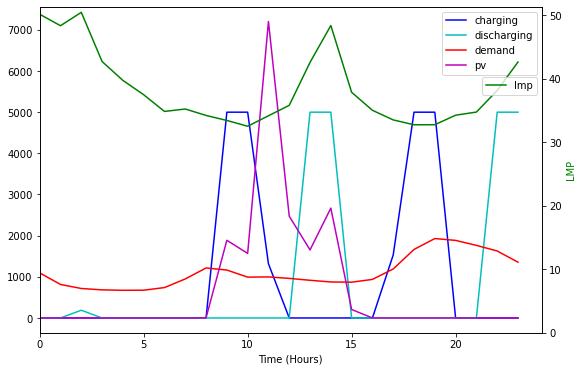

In [7]:
t = np.arange(n)
# demand given in kWh
p_dem_big = p_dem * 10 ** 3

fig,ax = plt.subplots(figsize=(9,6))
ax.plot(t, p_cha.value, 'b', label='charging')
ax.plot(t, p_dis.value, 'c', label='discharging')
ax.plot(t, p_dem_big, 'r', label='demand')
ax.plot(t, p_pv, 'm', label='pv')
plt.legend()
ax.set_xlabel('Time (Hours)')
ax2=ax.twinx()
ax2.plot(t, _lmp, 'g', label='lmp')
ax2.set_ylabel('LMP', color='g')
plt.legend(loc='upper right', bbox_to_anchor=(1., 0.8))
plt.axis((0, None, 0, None))
plt.show()


In [8]:
print("Charging                   Discharging              Demand                   LMP")
for i in range(n):
    print(p_cha.value[i], "    ", p_dis.value[i], "    ", p_dem[i], "    ", _lmp[i])

Charging                   Discharging              Demand                   LMP
-6.41600197510941e-09      6.811577407924972e-09      1.0954725932610998      50.17707
-6.1212920351933515e-09      6.513749109293112e-09      0.81428284432384      48.37496
-5.561433396225986e-09      187.99999985373412      0.7162871129227071      50.48109
1.1362124187398119e-07      -1.208924371972077e-07      0.682698254822347      42.73274
4.584702971711565e-07      -4.878024482617896e-07      0.672265810711454      39.75889
1.7139547968541065e-06      -1.8235820933208626e-06      0.67463152975952      37.50306
6.373799980045767e-06      -6.781459230066245e-06      0.7385109149235558      34.87104
2.3693917440976757e-05      -2.5209338877284255e-05      0.9480906362431378      35.25316
8.807819776034297e-05      -9.37115472523086e-05      1.2152092021949699      34.23951
5000.000327419255      -0.0003483604933666558      1.1643065579182499      33.45005
5000.000309819638      -0.0003296352180146538   